Importing frameworks

In [15]:
from sklearn.datasets import fetch_openml
from numpy import dot ,linalg , mean
from pandas import DataFrame  ,concat
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold , LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
import time

In [2]:
dataSize = 10000
kfold = 10

 Fetch Data from open ml

In [3]:

mnist = fetch_openml('mnist_784')
mnistData: DataFrame = mnist.data[:dataSize]
mnistTarget: DataFrame = mnist.target[:dataSize]


In [8]:
mnistData

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
mnistTarget

,class
0,5
1,0
2,4
3,1
4,9
...,...
9995,5
9996,8
9997,6
9998,9


Metric fuction using cosine function

In [7]:
trainSet = mnistData[:dataSize*8//10]
testSet = mnistData[dataSize*8//10:]

In [6]:
def metric(q, p):
    dotProduct = dot(q, p)
    magnitudeProduct = linalg.norm(q) * linalg.norm(p)
    return dotProduct / magnitudeProduct

In [5]:
def predict(x: DataFrame, trainSet: DataFrame, k: int):
    kNearestNeighbors = []

    for i in range(len(trainSet.index)):
        targetIndex = trainSet.index[i]
        sim = metric(x.to_numpy(), trainSet.iloc[i].to_numpy())
        kNearestNeighbors = sorted(
            kNearestNeighbors, key=lambda neighbor: -neighbor["sim"])

        if len(kNearestNeighbors) < k:
            kNearestNeighbors.append(
                {"label": mnistTarget.loc[targetIndex], "sim": sim})
        elif sim > kNearestNeighbors[-1]["sim"]:
            kNearestNeighbors.pop()
            kNearestNeighbors.append(
                {"label": mnistTarget.loc[targetIndex], "sim": sim})

    counts = [0] * 10
    for neighbor in kNearestNeighbors:
        counts[int(neighbor["label"])] += 1
    maxCount = max(counts)
    label = [i for i, count in enumerate(counts) if count == maxCount]

    return str(label[0])


In [4]:
def Kaccuracy(k: int):
    accuracy = []
    for i in range(kfold):
        firstIndex = i*(len(trainSet.index)//kfold)
        lastIndexIndex = (i+1)*(len(trainSet.index)//kfold)

        kfoldDataSet = trainSet[firstIndex: lastIndexIndex]
        newTrainSet = concat(
            [trainSet[0: firstIndex], trainSet[lastIndexIndex:]])

        rightClassification = 0
        for i in range(len(kfoldDataSet.index)):
            print(i)
            predictLabel = predict(kfoldDataSet.iloc[i], newTrainSet, k)

            realLabel = mnistTarget[kfoldDataSet.index[i]]
            if (predictLabel == realLabel):
                rightClassification += 1

        accuracy.append(
            float("%.2f" % (rightClassification / len(kfoldDataSet.index))))

    return float("%.2f" % mean(accuracy))

Use this code to make plot of k accuracies

*Commented lines run in my own pc*

In [ ]:
accuracies = []
usedK = []
for i in range(15):
    accuracies.append(Kaccuracy((2*i)+1))
    usedK.append((2*i)+1)

plt.figure(figsize=(10, 5))
plt.plot(usedK, accuracies, marker='o', linestyle='dashed', color='b')
plt.title('Cross validation scores for different k')
plt.xlabel('K')
plt.ylabel('Cross validation accuracy')
plt.grid(True)
plt.show()

this k accuracy on trainset using 10-fold(kfold) with 1000 of samples

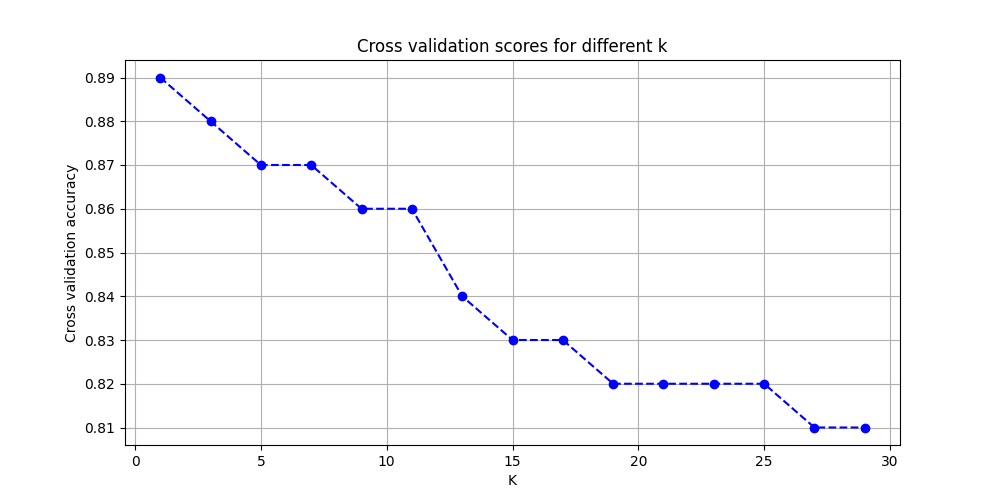

this k accuracy on trainset using 10-fold(kfold) with 10000 of samples , with cosine

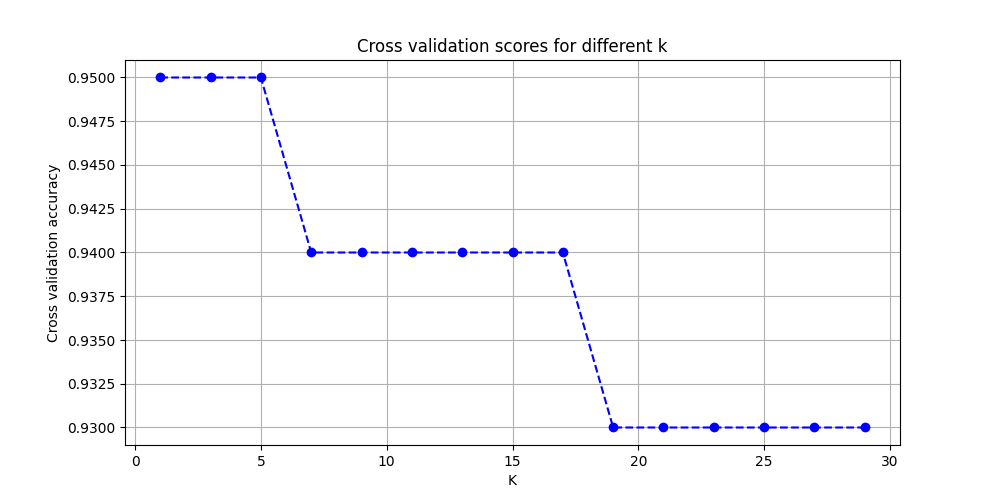

this k accuracy on trainset using 10-fold(kfold) with 10000 of samples , with euclidean metrics

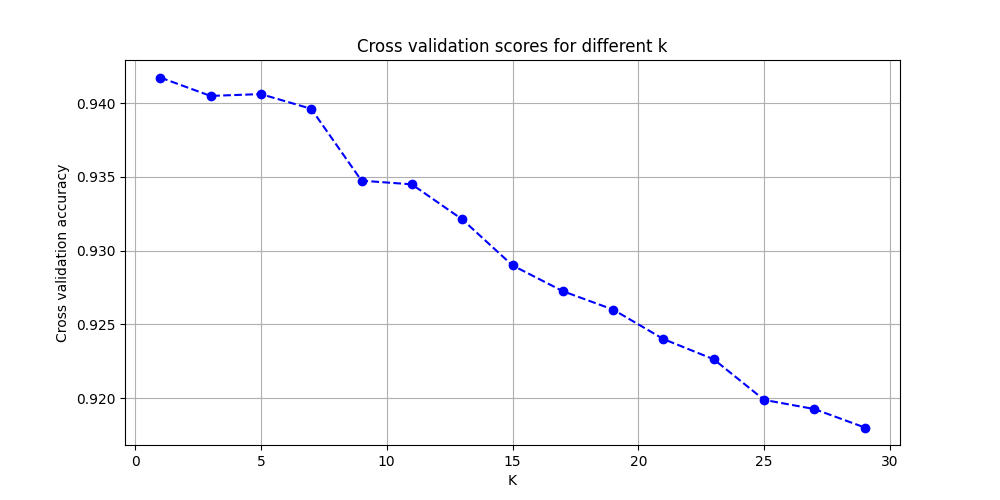

In [ ]:
accuracies = []
usedK = []

for i in range(15):
    k = (i*2) + 1

    usedK.append(k)

    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    knn.fit(trainSet, mnistTarget.loc[trainSet.index])
    predicts = knn.predict(testSet)

    rightClassification = 0
    for j in range(len(testSet.index)):
        predictLabel = predicts[j]
        realLabel = mnistTarget[testSet.index[j]]
        if (predictLabel == realLabel):
            rightClassification += 1

    accuracies.append(
            (rightClassification / len(testSet.index)))



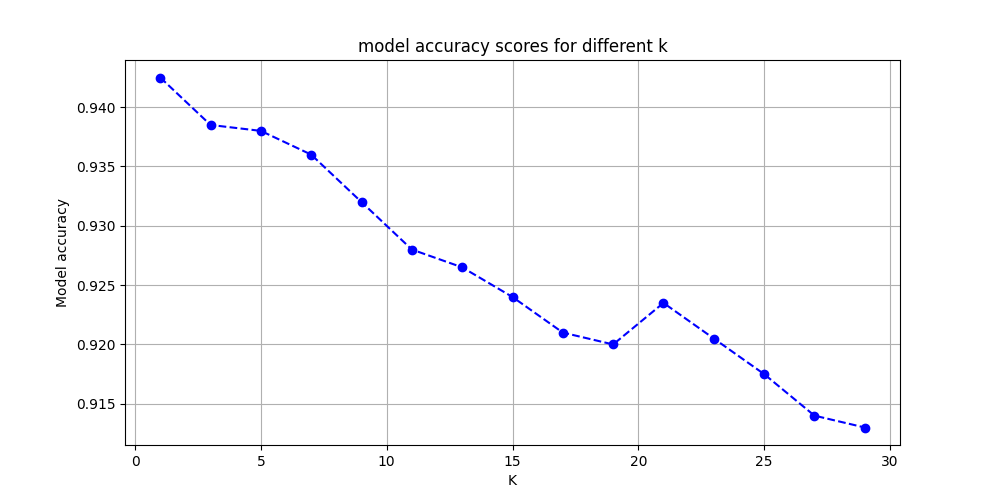

In [13]:
def removeAmbiguousSamples(dataSet, target, k):
    knn = KNeighborsClassifier(n_neighbors=k , metric="cosine")
    loo = LeaveOneOut()
    ambiguousIndices = []

    for trainIndex, testIndex in loo.split(dataSet):
        trainData, testSample = dataSet.iloc[trainIndex], dataSet.iloc[testIndex]
        trainTarget, testTarget = target.iloc[trainIndex], target.iloc[testIndex]

        knn.fit(trainData, trainTarget)
        predict = knn.predict(testSample)

        if predict[0] != testTarget.values[0]:
            ambiguousIndices.append(testIndex[0])

    ambiguousIndices = list(set(ambiguousIndices))

    cleanedDataSet = dataSet.drop(index=ambiguousIndices)
    cleanedTarget = target.drop(index=ambiguousIndices)

    return cleanedDataSet, cleanedTarget


In [ ]:
cleanedDataSet, cleanedTarget   = removeAmbiguousSamples(trainSet, mnistTarget, 1)

In [ ]:
start = time.time()

k = 1


knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
knn.fit(trainSet, mnistTarget.loc[trainSet.index])
predicts = knn.predict(testSet)

rightClassification = 0
for j in range(len(testSet.index)):
    predictLabel = predicts[j]
    realLabel = mnistTarget[testSet.index[j]]
    if (predictLabel == realLabel):
        rightClassification += 1

print(
    (rightClassification / len(testSet.index)))

end = time.time()
print("time measure in cleaned dataset", end - start)

Accuracy in normal 1nn : `0.9425`

time in normal 1nn : `0.4150214195251465`

In [ ]:

start = time.time()

k = 1
knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
knn.fit(cleanedDataSet, cleanedTarget.loc[cleanedDataSet.index])
predicts = knn.predict(testSet)

rightClassification = 0
for j in range(len(testSet.index)):
    predictLabel = predicts[j]
    realLabel = mnistTarget[testSet.index[j]]
    if (predictLabel == realLabel):
        rightClassification += 1

print(
    (rightClassification / len(testSet.index)))

end = time.time()
print("time measure in cleaned dataset", end - start)


Accuracy in removeAmbiguousSamples 1nn : `0.939`

time in removeAmbiguousSamples 1nn : `0.33756589889526367`

After running each algorythm 50 times 

P_value = 1.64 * 10^-8

that shows there is meaningful difference between two methods

and second method is much better